# Phase Estimation and its Qiskit Implementation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms and implements a measurement for essentially any Hermitian operator. Recall that a quantum computer initially only permits us to measure individual qubits. If we want to measure a more complex observable, such as the energy described by a Hamiltonian $H$, we resort to quantum phase estimation.


## Quantum Circuit for Phase Estimation 

The general quantum circuit for phase estimation is:
<img src="images/qpe.png">

This circuit estimates the phase of a unitary operator $U$, that is, it estimates $\theta$ in $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have an absolute value of 1. The circuit involves the following steps:

1. **Setup**: $|\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form an ancilla register: $$ \psi_1 = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$ 

2. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the ancilla register: $$ \psi_2 = {\frac {1}{2^{\frac {n}{2}}}}(|0\rangle +|1\rangle )^{\otimes n} \lvert \psi \rangle$$

3. **Controlled Unitary Operations**: We need to introduce the controlled unitary $C-U$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operatory with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means: $U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$. Applying all the $n$ controlled operations $C − U^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =(|0\rangle +e^{2\pi i\theta }|1\rangle )\otimes |\psi \rangle$:
\begin{aligned}
\psi_{3} & =\frac {1}{2^{\frac {n}{2}}} (|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle ) \otimes \cdots (|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}|1\rangle ) \otimes (|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}|1\rangle ) \otimes |\psi\rangle\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes |\psi\rangle\\
\end{aligned}
where $|k\rangle$ denotes the binary representation of $k$. 

4. **Inverse Fourer Transform**: Apply an inverse Fourier transform on the ancilla register:
$$\frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle$$ which we can rewrite by rounding $2^n\theta$ to the nearest integer, meaning $2^n \theta = a + 2^n\delta$ where $a$ is the nearest integer to $2^n\theta$, and the difference $2^n\delta$ satisfies $0\leq |2^n\theta|\leq \frac{1}{2}$: $$\psi_4 \approx \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - a)}e^{2\pi i \delta k} |x\rangle \otimes |\psi\rangle$$

5. **Measurement**: Measuring in the computational basis, we get the phase in the ancilla register: $$ |\psi_5\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$

# Qiskit Implementation

Let's first prepare our environment.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
π = np.pi

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

As an example, let us take a $2\times 2$ unitary matrix that is defined via the Hamiltonian $\frac{1}{2}\begin{bmatrix}3 & 1 \\1 & 3\end{bmatrix}$, which has eigenvectors of powers of two. 

Starting with $|\psi\rangle=|0\rangle$ in the main register (1 qubit), we prepare the superposition in the ancilla (2 qubits):

In [2]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1]);

Next we perform the controlled unitary operations:

In [3]:
# Controlled-U0
qpe.cu3(-π / 2, -π / 2, π / 2, q[1], q[2])
qpe.cu1(3 * π / 4, q[1], q[2])
qpe.cx(q[1], q[2])
qpe.cu1(3 * π / 4, q[1], q[2])
qpe.cx(q[1], q[2])

# Controlled-U1
qpe.cx(q[0], q[2]);

We apply quantum inverse Fourier transformation to write the phase to the ancilla register:

In [4]:
qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cu1(-π / 2, q[0], q[1])
qpe.h(q[0]);

We then measure the ancilla register:

In [5]:
qpe.measure(q[0],c[0])
qpe.measure(q[1],c[1])

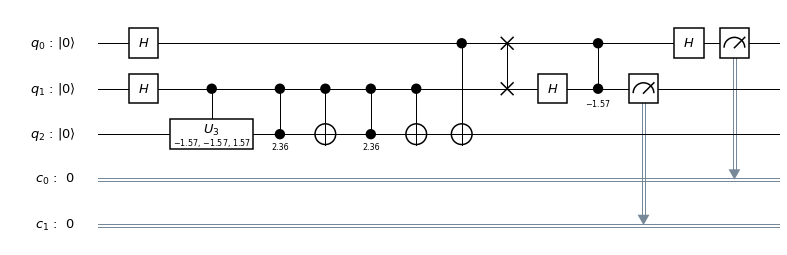

In [6]:
qpe.draw(output="mpl")

## Experiment with Simulators

We can run the above circuit on the simulator. 

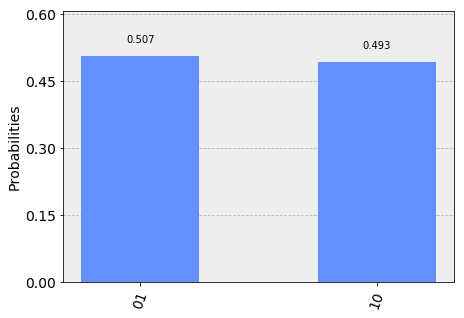

In [7]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

## Experiment with Real Devices

We can run the circuit on the real device as shown below.

In [8]:
# Load our saved IBMQ accounts and get the least busy backend device
IBMQ.load_accounts()
IBMQ.backends()
backend_lb = least_busy(IBMQ.backends(simulator=False))
print("Least busy backend: ", backend_lb)

Least busy backend:  ibmqx2


In [9]:
# run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 1024
job_exp = execute(qpe, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

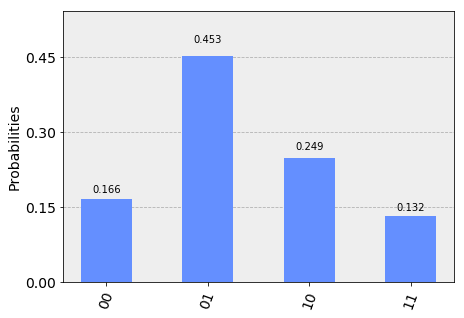

In [10]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(qpe)
plot_histogram(answer)

# Another Example

In [1]:
'''
    Quantum Phase Estimation

    Problem. Given an unitary operator U, estimate θ in U|ψ>=exp(2πiθ)|ψ>.

'''
import math

from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute


def qft_dagger(circuit, q, n):
    for j in range(n):
        k = (n-1) - j
        for m in range(k):
            circuit.cu1(-math.pi/float(2**(k-m)), q[k], q[m])
        circuit.h(q[k])


qr = QuantumRegister(3)  # Initialize qubits
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

# Prepare |ψ> = 1
circuit.x(qr[2])

circuit.barrier()

# Apply Hadamard to ancilla qubits
circuit.h(qr[0])
circuit.h(qr[1])

circuit.barrier()

# Controlled unitary operations
circuit.iden(qr[0])
circuit.cz(qr[1], qr[2])

circuit.barrier()

# Apply inverse quantum Fourier transform and measure ancilla qubits
qft_dagger(circuit, qr, 2)

circuit.measure(qr[0], cr[0])
circuit.measure(qr[1], cr[1])

# Run our circuit with local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)

{'00': 112, '11': 119, '10': 674, '01': 119}


e:\developmentenvironments\anaconda3\envs\qiskit19_env\lib\site-packages\qiskit\util.py:109: DeprecationWarning: The QuantumCircuit.iden() method is deprecated as of 0.14.0, and will be removed no earlier than 3 months after that release date. You should use the QuantumCircuit.i() method instead.
  return func(*args, **kwargs)
